<a href="https://colab.research.google.com/github/SahrulRamadani04/modelKue/blob/main/After_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 1. Install dan import library
!pip install -q tensorflow
!pip install -q gdown

import os
import gdown
import zipfile
import requests
from tqdm import tqdm
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

In [6]:
# 2. Download file dari Google Drive via ID
!pip install -q gdown
import gdown

# ID file Google Drive
file_id = "1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4"
url = f"https://drive.google.com/uc?id={file_id}"
output_file = "resizeDataset.zip"

# Download file menggunakan gdown
gdown.download(url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4
From (redirected): https://drive.google.com/uc?id=1zOvunqZ3VAF4ZC4dhIc52HhCokgyRdR4&confirm=t&uuid=61d3225a-ac24-48a9-9d76-abb19a40ac33
To: /content/resizeDataset.zip
100%|██████████| 54.9M/54.9M [00:00<00:00, 230MB/s]


'resizeDataset.zip'

In [8]:
# 3. Ekstrak zip dataset
import zipfile

extract_dir = 'dataset'
with zipfile.ZipFile("resizeDataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

    base_dir = 'dataset'

In [9]:
# 4. Split data ke dalam folder: train, val, test
!pip install -q split-folders
import splitfolders

# Ganti path asal ke folder dataset kamu
input_dir = "dataset/resizeDataset"
output_split = "data_split"

# Lakukan split
splitfolders.ratio("dataset/resizeDataset", output="data_split", seed=1337, ratio=(.7, .2, .1))

Copying files: 1200 files [00:00, 4491.34 files/s]


In [10]:
# 5. Buat ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_dir = os.path.join(output_split, 'train')
val_dir = os.path.join(output_split, 'val')
test_dir = os.path.join(output_split, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [11]:
# 5. Augmentasi Gambar pada Data Training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Buat ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validation dan test, hanya normalisasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Directory ke hasil split
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Target ukuran gambar
img_height, img_width = 224, 224
batch_size = 64

# Load data dengan augmentasi untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # ganti dengan 'binary' jika klasifikasi 2 kelas
)

# Untuk validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Untuk testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # fine-tune nanti jika perlu

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ✅ learning rate baru
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# Fine-tune 30 layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile model setelah perubahan
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]


In [15]:
# 8. Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2510 - loss: 1.5006 - val_accuracy: 0.2500 - val_loss: 1.3983 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.2809 - loss: 1.4315 - val_accuracy: 0.2500 - val_loss: 1.3967 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.2846 - loss: 1.3962 - val_accuracy: 0.2500 - val_loss: 1.3960 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.2775 - loss: 1.4278 - val_accuracy: 0.2500 - val_loss: 1.3943 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.2720 - loss: 1.4027 - val_accuracy: 0.1708 - val_loss: 1.3913 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.3109 - loss: 1.3928 - val_accuracy: 0.2958 - val_loss: 1.3898 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.

In [16]:
# 9. Evaluate
loss, acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2826 - loss: 1.3783

Test Accuracy: 28.33%


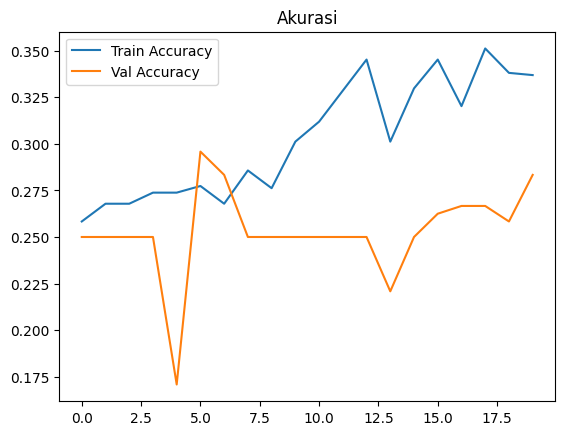

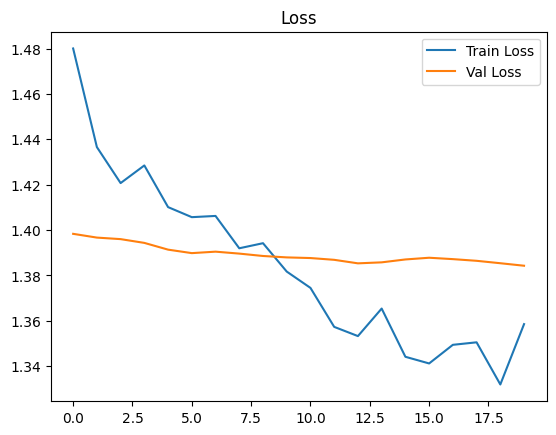

In [17]:
import matplotlib.pyplot as plt

# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Akurasi')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Found 120 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


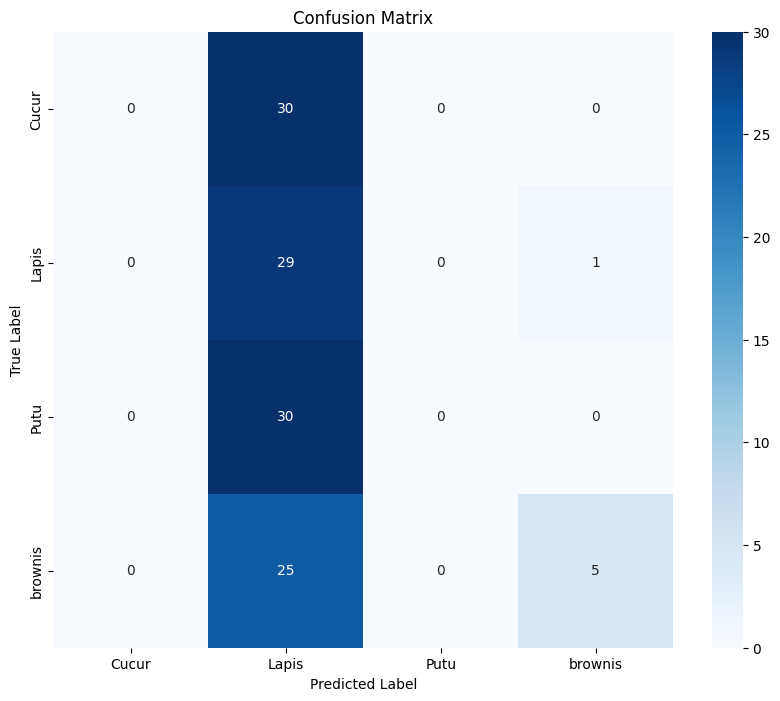

              precision    recall  f1-score   support

       Cucur       0.00      0.00      0.00        30
       Lapis       0.25      0.97      0.40        30
        Putu       0.00      0.00      0.00        30
     brownis       0.83      0.17      0.28        30

    accuracy                           0.28       120
   macro avg       0.27      0.28      0.17       120
weighted avg       0.27      0.28      0.17       120



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Buat generator untuk test set (tanpa augmentasi, hanya rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data_split/test',  # ubah jika path test kamu beda
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # penting agar urutan label sama dengan prediksi
)

# 2. Prediksi
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# 3. Label kelas
class_labels = list(test_generator.class_indices.keys())

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_labels))

Saving B170172-Cover-resep-putu-ayu-scaled.jpg to B170172-Cover-resep-putu-ayu-scaled.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


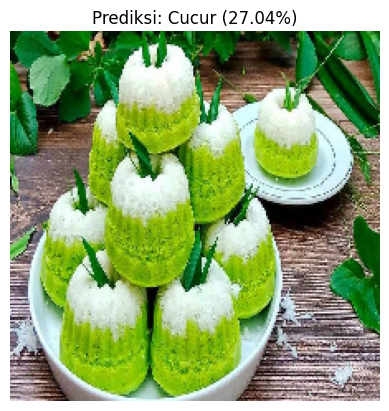

In [19]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# 1. Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    # 2. Load dan preprocess gambar
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # sesuai preprocessing training

    # 3. Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = list(train_gen.class_indices.keys())
    predicted_label = class_labels[predicted_class]
    confidence = np.max(prediction) * 100

    # 4. Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediksi: {predicted_label} ({confidence:.2f}%)')
    plt.show()